In [1]:
import torch
from torch import nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# nv = 3
# nh = 3
# n = nv + nh

nv = 97
nh = 97
n = nv + nh

In [3]:
learning_rate = 1e-4
epochs = 10
batch_size = 100
k = 3      


In [4]:
#basic test training
N = 10000
states = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
idx = np.random.choice(np.arange(len(states)), N)
data = states[idx]
data = torch.from_numpy(data)
train_loader = torch.utils.data.DataLoader(dataset = data.to(torch.float), batch_size = batch_size, shuffle = True)


Shape of train and test datasets
torch.Size([500, 97, 1])
torch.Size([500, 3, 1])
torch.Size([100, 97, 1])
torch.Size([100, 3, 1])


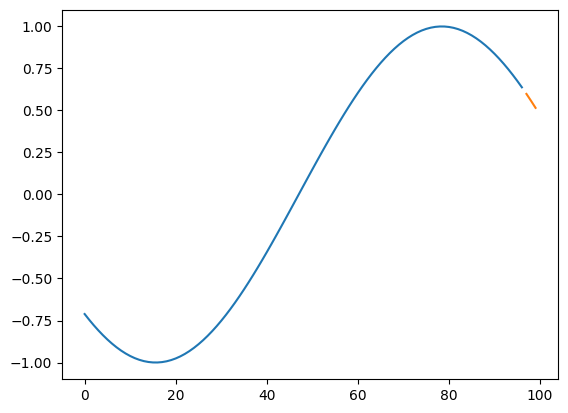

In [5]:
#real training
N = 10 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)


wind_size = 100
y_windowed = []
x_wind = []
y_wind = []

for i in range(wind_size,L):
    curr = y[:,i-wind_size:i]
    res = np.swapaxes(curr,0,1)
    x_wind.append(res[0:97])
    y_wind.append(res[-3:])

x_wind = np.array(x_wind)[:,:,0:1]
y_wind = np.array(y_wind)[:,:,0:1]

x_train = torch.from_numpy(x_wind[0:500])
y_train = torch.from_numpy(y_wind[0:500])
x_test = torch.from_numpy(x_wind[800:])
y_test = torch.from_numpy(y_wind[800:])
print("Shape of train and test datasets")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_axis_test = np.arange(0,100)
plt.plot(x_axis_test[0:97],x_wind[5,:,0])
plt.plot(x_axis_test[-3:],y_wind[5,:,0])
plt.show()

In [40]:
x_train.reshape(500,97).shape
y_train.reshape(500,3).shape
# train_loader = torch.utils.data.DataLoader(dataset = x_train.reshape(500,97).to(torch.float), batch_size = 1, shuffle = False)
train_loader = torch.utils.data.DataLoader(list(zip( x_train.reshape(500,97).to(torch.float), y_train.reshape(500,3).to(torch.float))), 
                                           batch_size = 1, 
                                           shuffle = False)

In [175]:
class RBM(torch.nn.Module):   
	def __init__(self,visible_size,hidden_size,init_var=1e-0,cd_step=1,cd_burning=0):
		super().__init__()
		self.cd_step = cd_step
		self.cd_burning = cd_burning
		self.visible_size = visible_size
		self.hidden_size = hidden_size
		self.init_var = init_var
		
		self.linear_layer = nn.Linear(hidden_size,3)
		self.W = nn.Parameter(torch.Tensor(visible_size, hidden_size))
		self.b = nn.Parameter(torch.Tensor(hidden_size))
		self.mu = nn.Parameter(torch.Tensor(visible_size))
		self.log_var = nn.Parameter(torch.Tensor(visible_size))
		self.reset_parameters()

	def reset_parameters(self):
		nn.init.normal_(self.W,
                        std=1.0 * self.init_var /
                        np.sqrt(self.visible_size + self.hidden_size))
		nn.init.constant_(self.b, 0.0)
		nn.init.constant_(self.mu, 0.0)
		nn.init.constant_(self.log_var,
                          np.log(self.init_var))  # init variance = 1.0

	def get_var(self):
		return self.log_var.exp().clip(min=1e-8)

	@torch.no_grad()
	def CD_grad(self,v):
		v = v.view(v.shape[0], -1)
		prob_h, h, pos_eng = self.positive_energy(v)

		# negative gradient
		v_neg = torch.randn_like(v)
		neg_eng = self.negative_grad(v_neg)

		return [pos_eng,neg_eng]
		for name, param in self.named_parameters():
			param.grad = pos_eng[name] - neg_eng[name]
	
	@torch.no_grad()
	def negative_grad(self, v):
		var = self.get_var()
		var_mean = var.mean().item()
		samples = self.Gibbs_sampling_vh(v,
										num_steps=self.cd_step,
										burn_in=self.cd_burning)
		v_neg = torch.cat([xx[0] for xx in samples], dim=0)
		h_neg = torch.cat([xx[1] for xx in samples], dim=0)
		grad = self.energy_grad_param(v_neg, h_neg)
		return grad
	
	@torch.no_grad()
	def Gibbs_sampling_vh(self, v, num_steps=10, burn_in=0):
		samples, var = [], self.get_var()
		std = var.sqrt()
		h = torch.bernoulli(self.prob_h_given_v(v, var))
		for ii in range(num_steps):
            # backward sampling
			mu = self.prob_v_given_h(h)
			v = mu + torch.randn_like(mu) * std

            # forward sampling
			h = torch.bernoulli(self.prob_h_given_v(v, var))
			if ii >= burn_in:
				samples += [(v, h)]
		return samples
	
	@torch.no_grad()
	def prob_h_given_v(self, v, var):
		return torch.sigmoid((v / var).mm(self.W) + self.b)

	@torch.no_grad()
	def prob_v_given_h(self, h):
		return h.mm(self.W.T) + self.mu

	@torch.no_grad()
	def positive_energy(self, v):
		prob_h = self.prob_h_given_v(v, self.get_var())
		h = torch.bernoulli(prob_h)
		pos_energy = self.energy_grad_param(v,h)
		return prob_h,h,pos_energy
	
	@torch.no_grad()
	def energy_grad_param(self, v, h):
        # compute the gradient (parameter) of energy averaged over batch size
		var = self.get_var()
		grad = {}
		grad['W'] = -torch.einsum("bi,bj->ij", v / var, h) / v.shape[0]
		grad['b'] = -h.mean(dim=0)
		grad['mu'] = ((self.mu - v) / var).mean(dim=0)
		grad['log_var'] = (-0.5 * (v - self.mu)**2 / var +
		                   ((v / var) * h.mm(self.W.T))).mean(dim=0)
		return grad
	
	def sample_h(self, v):
		# phv = torch.sigmoid(torch.matmul(v, self.w) + self.b)
		# h = torch.bernoulli(phv)
		# return h, phv
		h = torch.normal(mean=torch.matmul(v, self.w) + self.b,std=self.sigma_b)
		return h
	
	@torch.no_grad()
	def reconstruction(self, v):
		v, var = v.view(v.shape[0], -1), self.get_var()
		prob_h = self.prob_h_given_v(v, var)
		v_bar = self.prob_v_given_h(prob_h)
		return F.mse_loss(v, v_bar)
	    
	def compute_linear_layer(self,data):
		el = self.Gibbs_sampling_vh(data,1,0)
		return self.linear_layer(el[0][0])

	def sample_v(self, h):
		# pvh = torch.sigmoid(torch.matmul(h, self.w.t()) + self.a)
		# v = torch.bernoulli(pvh)
		# return v, pvh
		v = torch.normal(mean=torch.matmul(h,self.w.T) + self.a,std=self.sigma_a)
		return v
	    
	def forward(self, v):
		h = self.sample_h(v)
		#gibbs sampling
		for i in range(k):	
			v = self.sample_v(h)
			h= self.sample_h(v)
			v= self.sample_v(h)
			return v
		
	def predict(self,v):
		h = self.sample_h(v)
		return(h)
	    
	def free_energy(self, v):
		# vt = torch.matmul(v, self.a)
		# ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim = 1)
		# return -(vt + ht)

		vt = torch.matmul(v,self.a)
		vvt = torch.matmul(v,v.T)*0.5
		aat = torch.matmul(self.a,self.a)*0.5
		hm = torch.sum(torch.log(1+torch.exp(torch.matmul(v,self.w)+self.b)))
		# ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim = 1)
		return -vt +vvt + aat -hm

In [176]:
def train(rbm, train_loader, k, optimizer,criterion_loss,clipping=0,device="cpu"):
	rbm.train()
	# for ii, (data, _) in enumerate(tqdm(train_loader)):
	for ii, (data,target)  in enumerate(train_loader):
		optimizer.zero_grad()
		[pos_eng,neg_eng] = rbm.CD_grad(data)
		if clipping > 0:
			nn.utils.clip_grad_norm_(rbm.parameters(), clipping)
		
		pred = rbm.compute_linear_layer(data)
		linear_loss = criterion_loss(pred,target)
		linear_loss.backward()

		for name, param in rbm.named_parameters():
			if "linear_layer" not in name:
				param.grad = pos_eng[name] - neg_eng[name]

		optimizer.step()
		if ii == len(train_loader) - 1:
			recon_loss = rbm.reconstruction(data).item()
		# batch = batch.view(-1, nv).to(device)
		# v = rbm.forward(batch.view(-1)).to(device)
		# cost = torch.mean(rbm.free_energy(batch)) - torch.mean(rbm.free_energy(v))
		# cost = cost.to(device)
		# epoch_cost += cost.item()
		# optimizer.zero_grad()
		# cost.backward()
		# optimizer.step()
		# print('Epoch [{}/{}], cost: {:.4f}'.format(epoch+1, training_epochs, epoch_cost))
	return recon_loss + linear_loss

In [190]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clipping = 10.0
learning_rate = 1e-4
training_epochs = 50
model = RBM(nv, nh).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion_loss = nn.MSELoss()

#multiplicative lr
lmbda = lambda training_epochs: 0.65 ** training_epochs
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
#cosine anneling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, training_epochs)

lrs = []
loss_list = []
for epoch in range(training_epochs):
    print("Current epoch :{}".format(epoch),end="\r")
    loss = train(model, train_loader,k,optimizer,criterion_loss,clipping,"cpu")
    loss_list.append(loss)
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Current epoch :{} , current error: {}".format(epoch,loss),end="\r")
    print("")


Current epoch :0 , current error: 2.3366894721984863
Current epoch :1 , current error: 0.7966407537460327
Current epoch :2 , current error: 0.709412693977356
Current epoch :3 , current error: 0.16199472546577454
Current epoch :4 , current error: 0.32276207208633423
Current epoch :5 , current error: 0.4405636489391327
Current epoch :6 , current error: 0.6822762489318848
Current epoch :7 , current error: 1.1152538061141968
Current epoch :8 , current error: 0.9938104748725891
Current epoch :9 , current error: 1.0513302087783813
Current epoch :10 , current error: 1.209633469581604
Current epoch :11 , current error: 1.386456847190857
Current epoch :12 , current error: 1.366353154182434
Current epoch :13 , current error: 1.404934287071228
Current epoch :14 , current error: 1.5248082876205444
Current epoch :15 , current error: 1.4583466053009033
Current epoch :16 , current error: 1.291817545890808
Current epoch :17 , current error: 1.3796501159667969
Current epoch :18 , current error: 1.47081

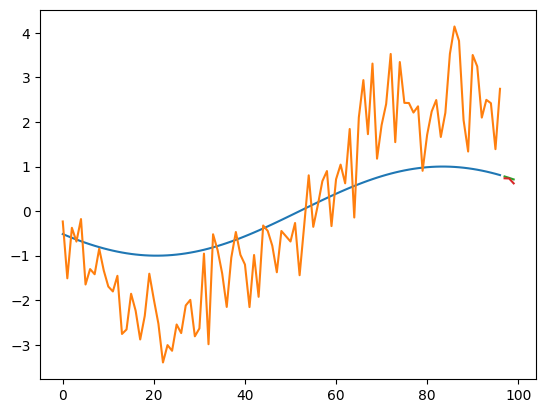

In [210]:
model.eval()
for idx, (data,target) in enumerate(train_loader):
    plt.plot(np.arange(data[0].size()[0]),data[0].detach().numpy())
    el = model.Gibbs_sampling_vh(data,10,0)
    plt.plot(np.arange(data[0].size()[0]),el[9][0][0].detach().numpy())
    plt.plot()

    pred = model.compute_linear_layer(data)
    pred_detached = pred[0].detach().numpy()
    plt.plot(np.arange(97,100),target[0].detach().numpy())
    plt.plot(np.arange(97,100),pred_detached)
    plt.show    
    # print(model.reconstruction(data))
    break



In [78]:
el[0][0][0].size()

torch.Size([97])

tensor([[ 0.8150,  0.0994, -0.7543,  0.2780,  0.1791, -1.7397, -1.9446,  0.3875,
          1.6345, -0.0810,  3.2175, -0.4969,  1.3375, -0.3316, -0.2367, -0.2780,
          0.2084,  0.6755, -0.7847,  1.0824,  0.6697, -0.7179, -0.5987, -0.5132,
          1.6594, -1.1474,  2.3361, -0.7586,  1.0284, -2.2064,  0.0538, -0.2185,
          0.0422,  1.8315,  0.4363, -0.2244,  0.6477,  1.6035,  1.2889, -1.5369,
         -0.7978,  1.2588,  0.8043,  0.3315, -1.1734, -0.3758,  0.0315,  0.3934,
          0.8685, -0.7271,  1.0756,  1.4819, -0.8851, -1.0825, -0.0942, -0.2020,
          0.2406, -0.7031,  0.6123,  0.6961, -0.6054,  0.1026,  2.0290, -0.5103,
         -0.9944,  0.9638, -1.4257, -0.4388, -0.1691,  0.6004,  1.1382,  0.2174,
          0.5585, -0.1850, -0.4877, -1.0977, -1.4632, -0.7434,  0.7652,  0.0602,
         -1.7003,  0.4793,  0.2532, -0.2037, -1.2466,  1.0678,  0.0328,  1.8162,
          0.1775, -1.6017,  0.2911,  1.5154,  1.6075,  0.9719,  0.2402,  0.6923,
          1.5587]], device='

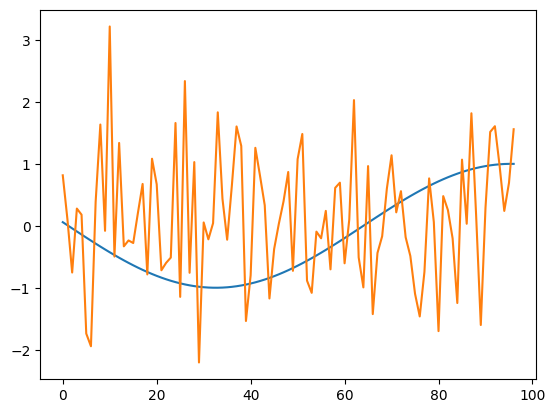

In [74]:
for batch in train_loader:  
    el = batch.numpy()[0]
    plt.plot(np.arange(el.shape[0]),el)

    v = model.predict(batch).to(device)
    s = v.cpu().detach().numpy()[0]
    plt.plot(np.arange(s.shape[0]),s)
    print(v)
    break